In [991]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import pandas as pd

from utils.basic_utils import read_dates, load_csvs, csv_load
from utils.pricing import *
from utils.fundamental import filter_cols
from matplotlib import pyplot as plt

pd.options.display.float_format = '{:,.3f}'.format

In [992]:
# utility functions
def top_recomm_by_class(pred_df, labels, top_items):
    mask = pred_df.hard_pred_label == pred_df.soft_pred_label
    agree_df = pred_df.loc[mask].drop_duplicates()
    # should add sector and industries, group for allocation insights
    # should add marketcap, beta, etc, group for risk exposure insights
    label_mask = agree_df.soft_pred_label.isin(['bear', 'short', 'long', 'bull'])
    return agree_df.loc[label_mask]\
        .sort_values(by='soft_confidence', ascending=False)\
        .groupby(by='soft_pred_label').head(top_items)\
        .sort_values(by='soft_pred_class')

def pred_distrib(pred_df, count_col):
    dist = pd.value_counts(pred_df[count_col]).to_frame()
    dist['weights'] = dist / dist.sum()
    return dist

def add_desc_stats(df, descriptive_cols):
    tickers = df.index
    for k in descriptive_cols.keys():
        desc_df, cols = descriptive_cols[k]['df'], descriptive_cols[k]['columns']
        for c in cols: df.loc[:, c] = tickers.map(desc_df[c].to_dict()).values 
    return df

def clean_df(df, large_vals, div_cols):
    # convert large values to billions
    df.loc[:, large_vals] = df.loc[:, large_vals] / 10**9
    df.loc[:, div_cols] = df[div_cols].div(df.regularMarketPrice, axis=0)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

q_group = lambda x, q: x.quantile(q)

In [993]:
hard_vote, soft_vote = 'hard_pred_label', 'soft_pred_label'

In [994]:
# s3 paths
s3_path = {
    'macro': 'recommend/macro_ML/',
    'micro': 'recommend/micro_ML/',
    'fin_data': 'recommend/fdmn_ML-fin_data/',
    'key_statistics': 'recommend/fdmn_ML-key_statistics/',
    'eps_trend': 'recommend/fdmn_ML-eps_trend/',
    'eps_estimates': 'recommend/fdmn_ML-eps_estimates/',
    'day_quote': 'recommend/fdmn_ML-day_quote/',
    'iv_value': 'valuation/waterfall/'
}

In [995]:
# context / descriptive data
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3

quotes = load_csvs('quote_consol', [tgt_date])
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

keystats = load_csvs('summary_detail', ['defaultKeyStatistics/' + str(tgt_date)])
keystats.set_index('symbol', drop=False, inplace=True)
1
finstats = load_csvs('summary_detail', ['financialData/' + str(tgt_date)])
finstats.set_index('symbol', drop=False, inplace=True)

Loading file quote/csv/2019-04-05
Loading file summary-categories/assetProfile
Loading file summary-categories/defaultKeyStatistics/2019-04-05
Loading file summary-categories/financialData/2019-04-05


### Macro / risk-exposure ML

In [996]:
# Read macro predictions
bench = '^GSPC'
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

key = 'macro'
macro_df = pd.read_csv(csv_load(f'{s3_path[key]}{tgt_date}'), index_col='pred_date', parse_dates=True)
macro_df.tail()

,^GSPC,hard_pred_class,hard_pred_label,soft_pred_class,soft_pred_label,soft_confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,,,
2019-04-01,"2,867.190",3,long,3,long,0.689,0.000,0.029,0.234,0.689,0.047
2019-04-02,"2,867.240",3,long,3,long,0.719,0.000,0.022,0.205,0.719,0.054
2019-04-03,"2,873.400",3,long,3,long,0.731,0.000,0.020,0.188,0.731,0.061
2019-04-04,"2,879.390",3,long,3,long,0.782,0.000,0.020,0.177,0.782,0.021
2019-04-05,"2,892.740",3,long,3,long,0.770,0.000,0.014,0.203,0.770,0.014


'Confidence Mean: 0.892, Median 0.935'

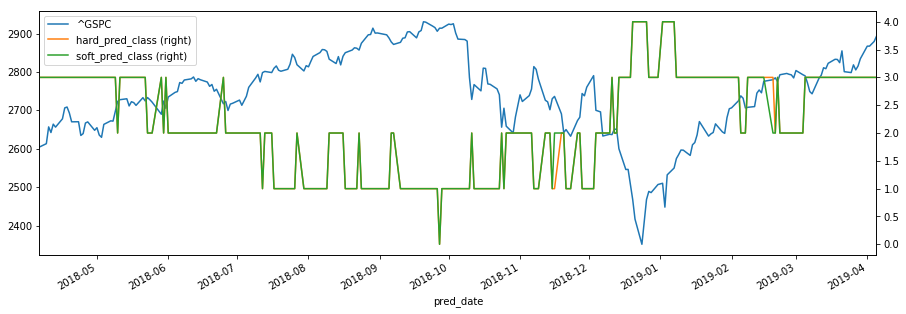

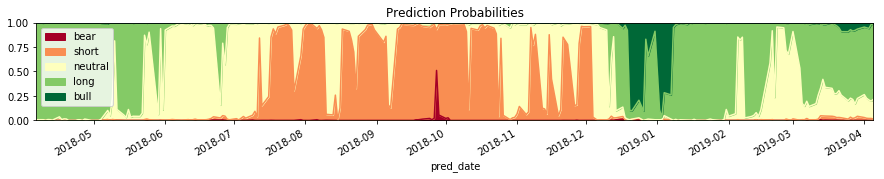

In [997]:
# Visualize macro predictions
pred_df = macro_df
pre_class_cols = filter_cols(pred_df.columns, "pred_class")
pred_df.loc[:,[bench] + pre_class_cols].plot(
    secondary_y=pre_class_cols, 
    figsize=(15, 5));
pred_df[fwd_ret_labels].plot.area(
        title='Prediction Probabilities',
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn');
f'Confidence Mean: {pred_df["soft_confidence"].mean().round(3)}, Median {pred_df["soft_confidence"].median().round(3)}'

### Intrinsic Value

In [969]:
path = 'valuation/waterfall/'
print(f'Loading {path}{tgt_date}')
val_df = pd.read_csv(csv_load(path+tgt_date), parse_dates=True)
val_df.set_index('symbol', inplace=True)
val_df.dropna(subset=['premDisc'], inplace=True)
val_df = val_df.loc[(np.abs(val_df.premDisc) < val_df.premDisc.median() * 3).values, :]

iv_mapper = (1 - val_df.loc[(val_df['premDisc'] < 3) & (val_df['premDisc'] > 0), 'premDisc']).to_dict()

Loading valuation/waterfall/2019-04-04


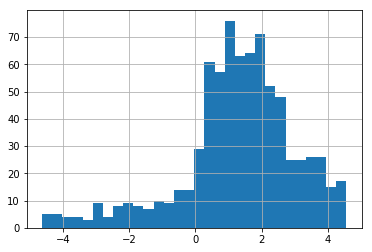

In [888]:
# Intrinsic value distribution
val_df.premDisc.hist(bins=30);

### Bottom-up MLs

In [889]:
key = 'fin_data'
agg_funcs = ['count', 'mean', 'median', 'max']
model = 'micro'

re_index_col = 'symbol'
value_col = 'soft_confidence'
show = ['symbol', 'soft_confidence']
mask_col, class_value = 'soft_pred_label', 'bull'

show = ['symbol', 'hard_pred_label','soft_pred_label','soft_confidence']
show_classes = ['bear', 'short', 'long', 'bull']

descriptive_cols = {
    'quotes': { 'df': quotes, 'columns': ['forwardPE', 'trailingPE', 'marketCap', 'regularMarketPrice'],},
    'profile': { 'df': profile, 'columns': ['sector', 'industry', 'country'],},
    'keystats': { 'df': keystats, 'columns': ['pegRatio', 'shortPercentOfFloat'],},
    'finstats': { 'df': finstats, 'columns': ['earningsGrowth', 'recommendationMean', 'targetMeanPrice', 'targetMedianPrice', 'numberOfAnalystOpinions'],},
    'valuation': { 'df': val_df, 'columns': ['premDisc', 'growthRate'],},
}
large_vals = ['marketCap']
div_cols = ['targetMeanPrice', 'targetMedianPrice']

mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

g_by = ['sector', 'marketCap_label']
show_g_by = ['mean_score']

In [890]:
# Read ML predictions
fndm_dfs = {
    k: pd.read_csv(
        csv_load(f'{s3_path[k]}{tgt_date}'), 
        index_col='pred_date', 
        parse_dates=True)\
        for k in ('micro', 'fin_data', 'key_statistics', 
                  'eps_trend', 'eps_estimates', 'day_quote')
}

MICRO, 1181 unique symbols
FIN_DATA, 1156 unique symbols
KEY_STATISTICS, 1209 unique symbols
EPS_TREND, 1203 unique symbols
EPS_ESTIMATES, 1203 unique symbols
DAY_QUOTE, 1302 unique symbols


,micro,fin_data,key_statistics,eps_trend,eps_estimates,day_quote
bear,0.105,0.087,0.030,0.001,0.297,0.062
short,0.147,0.322,0.241,0.165,0.121,0.351
neutral,0.013,0.210,0.166,0.707,0.460,0.177
long,0.231,0.353,0.536,0.018,0.032,0.361
bull,0.504,0.028,0.027,0.110,0.091,0.048


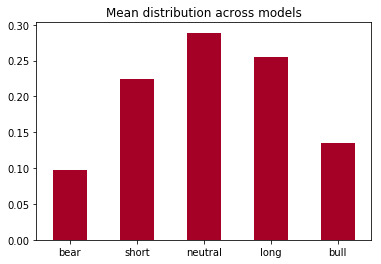

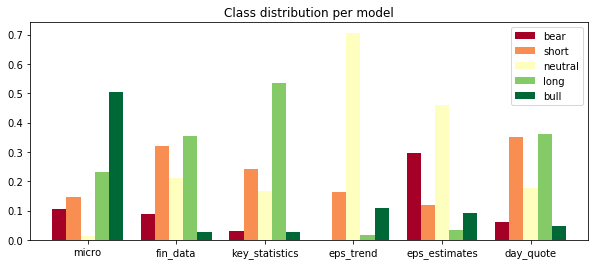

In [891]:
# Class distribution across models
column = 'weights'
super_list = []
for key in fndm_dfs.keys():
    df = fndm_dfs[key]
    print(f'{key.upper()}, {df.symbol.shape[0]} unique symbols')
    pred_df = pred_distrib(df, soft_vote).loc[fwd_ret_labels, column]
    pred_df.name = key
    super_list.append(pred_df)
class_distrib = pd.concat(super_list, axis=1, sort=True).loc[fwd_ret_labels, :]
class_distrib.mean(axis=1).plot(title='Mean distribution across models', kind='bar', rot=0, cmap='RdYlGn', )
class_distrib.T.plot.bar(title='Class distribution per model', stacked=False, cmap='RdYlGn', figsize=(10,4), width=0.8, rot=0)
class_distrib

In [892]:
# Descriptive statistics for a given model
print(f'Descriptive statistics for {model.upper()}')
fndm_dfs[model].groupby(by=soft_vote).agg(agg_funcs).loc[fwd_ret_labels, 'soft_confidence']

Descriptive statistics for MICRO


,count,mean,median,max
soft_pred_label,,,,
bear,124,0.359,0.332,0.743
short,174,0.324,0.309,0.503
neutral,15,0.298,0.280,0.415
long,273,0.344,0.334,0.636
bull,595,0.393,0.370,0.900


soft_pred_label distribution for MICRO


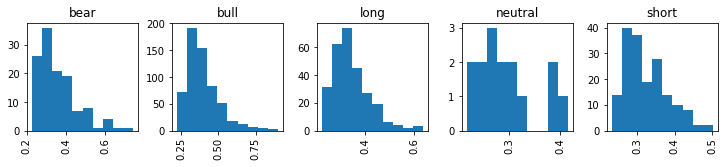

In [893]:
print(f'{soft_vote} distribution for {model.upper()}')
fndm_dfs[model].loc[:, [soft_vote, 'soft_confidence']].hist(
    by=soft_vote, figsize=(12,2), layout=(1,5));

In [985]:
### Merge predictions by class
super_list = []
for key in fndm_dfs.keys():
    df = fndm_dfs[key]
    df = df.loc[df[mask_col] == class_value, [re_index_col, value_col]].set_index(re_index_col)
    rename_col(df, value_col, key)
    super_list.append(df)
merged_df = pd.concat(super_list, axis=1, sort=True, join='outer')

# add intrinsic value premium or discount?
# merged_df.loc[:, 'intrinsic_val'] = merged_df.index.map(iv_mapper).values 
print(f'{list(merged_df.columns)}')
merged_df.fillna(0, inplace=True)

['micro', 'fin_data', 'key_statistics', 'eps_trend', 'eps_estimates', 'day_quote']


In [986]:
# Model score weights 
ml_score_dict = {
    'micro': 0.75, 'fin_data': 0.75, 'key_statistics': 0.7, 
    'eps_trend': 0.68, 'eps_estimates': 0.65, 
    'day_quote': 0.6, 
    'intrinsic_val': 0.7
}

model_scores = np.array(list(map(ml_score_dict.get, merged_df.columns)))
ml_weights = (model_scores - 0.5) / (model_scores - 0.5).sum()

In [987]:
merged_df['mean_score'] = (merged_df * ml_weights).sum(axis=1)

#### Descriptive summaries

In [988]:
# Add descriptive stats and clean up
desc_df = add_desc_stats(merged_df.copy(), descriptive_cols)
desc_df = clean_df(desc_df, large_vals, div_cols)

desc_df.loc[:, 'pegRatio'] = desc_df.forwardPE / (val_df.growthRate * 100)
desc_df.loc[:, 'marketCap_label'] = discret_rets(desc_df.marketCap, mkt_cap_cuts, mkt_cap_labels)

print(f'Dataframe shape: {desc_df.shape}, \nColumns: {desc_df.columns}')
desc_df.tail()

Dataframe shape: (691, 24), 
Columns: Index(['micro', 'fin_data', 'key_statistics', 'eps_trend', 'eps_estimates',
       'day_quote', 'mean_score', 'forwardPE', 'trailingPE', 'marketCap',
       'regularMarketPrice', 'sector', 'industry', 'country', 'pegRatio',
       'shortPercentOfFloat', 'earningsGrowth', 'recommendationMean',
       'targetMeanPrice', 'targetMedianPrice', 'numberOfAnalystOpinions',
       'premDisc', 'growthRate', 'marketCap_label'],
      dtype='object')


,micro,fin_data,key_statistics,eps_trend,eps_estimates,day_quote,mean_score,forwardPE,trailingPE,marketCap,regularMarketPrice,sector,industry,country,pegRatio,shortPercentOfFloat,earningsGrowth,recommendationMean,targetMeanPrice,targetMedianPrice,numberOfAnalystOpinions,premDisc,growthRate,marketCap_label
ZBRA,0.000,0.000,0.000,0.400,0.410,0.000,0.118,16.250,27.579,11.529,214.010,Industrials,Diversified Industrials,United States,inf,0.022,29.241,2.000,1.020,1.047,7.000,1.853,0.000,large
ZION,0.290,0.000,0.000,0.340,0.000,0.000,0.118,9.933,11.686,8.876,47.680,Financial Services,Banks - Regional - US,United States,0.415,0.147,0.985,2.000,1.146,1.133,24.000,0.301,0.239,mid
ZTO,0.000,0.000,0.000,0.470,0.400,0.000,0.128,16.202,20.614,14.508,18.470,Industrials,Integrated Shipping & Logistics,China,34.424,nan,-0.056,1.900,1.212,1.248,16.000,1.784,0.005,large
ZUO,0.785,0.290,0.000,0.000,0.000,0.000,0.238,-61.000,nan,2.184,20.130,Technology,Software - Infrastructure,United States,nan,0.269,nan,2.000,1.348,1.391,7.000,nan,nan,mid
^VIX,0.000,0.000,0.000,0.000,0.000,0.280,0.025,nan,nan,nan,13.580,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN


### Aggregate statistics

In [989]:
print(f'Model focus: {model.upper()}, predicted class: {class_value.upper()}, group by: {g_by}')

desc_df.groupby(by=g_by)[show_g_by].agg(agg_funcs).sort_values(
    by=(show_g_by[0], 'median'), ascending=False).head(10)
# desc_df.groupby(by=g_by)[show_g_by].apply(q_group, q=0.75)

Model focus: MICRO, predicted class: BULL, group by: ['sector', 'marketCap_label']


mean_score                   
                                            count  mean median   max
sector                 marketCap_label                              
Industrials            small                    5 0.166  0.156 0.321
Energy                 small                    3 0.125  0.135 0.181
Communication Services mid                      6 0.122  0.122 0.188
Healthcare             small                   14 0.143  0.119 0.339
Real Estate            small                    2 0.106  0.106 0.115
Technology             small                   11 0.126  0.104 0.281
Financial Services     small                    4 0.099  0.104 0.122
Healthcare             mid                     38 0.114  0.102 0.309
Technology             mid                     85 0.120  0.102 0.325
Energy                 large                   25 0.092  0.093 0.141

In [990]:
# ticker with most models above 0.5 confidence
df = desc_df
micro_ml_cols = list(fndm_dfs.keys())
desc_show_col = ['mean_score'] + micro_ml_cols + [
    'shortPercentOfFloat', 'premDisc', 'forwardPE', 'trailingPE', 'marketCap','marketCap_label',
    'sector', 'industry', 'country',
    'pegRatio', 'earningsGrowth', 'growthRate',
    'targetMeanPrice','targetMedianPrice','numberOfAnalystOpinions']

# top_tickers = df[micro_ml_cols].where(
#     df[micro_ml_cols] > 0.5).count(axis=1).sort_values(ascending=False)\
#     .head(10).index
top_tickers = df[show_g_by].index

print(f'Model focus: {model.upper()}, predicted class: {class_value.upper()}')
df.loc[top_tickers, desc_show_col].sort_values(by=show_g_by[0], ascending=False).head(10).T

Model focus: MICRO, predicted class: BULL


,ENDP,COHR,AVAV,NVDA,INGN,HQY,PLT,ULTA,TAL,STMP
mean_score,0.339,0.325,0.321,0.311,0.309,0.281,0.281,0.265,0.260,0.258
micro,0.795,0.552,0.786,0.445,0.520,0.487,0.900,0.472,0.667,0.422
fin_data,0.520,0.000,0.000,0.340,0.370,0.000,0.370,0.000,0.000,0.000
key_statistics,0.270,0.320,0.582,0.000,0.000,0.330,0.000,0.358,0.000,0.000
eps_trend,0.000,0.500,0.000,0.510,0.370,0.390,0.000,0.310,0.400,0.470
eps_estimates,0.000,0.500,0.000,0.420,0.000,0.400,0.000,0.360,0.370,0.400
day_quote,0.000,0.000,0.496,0.000,0.600,0.000,0.000,0.000,0.000,0.420
shortPercentOfFloat,0.089,0.108,0.152,NaN,0.341,0.111,0.097,0.031,NaN,0.223
premDisc,-0.141,2.612,NaN,NaN,1.690,3.635,-1.861,3.428,NaN,NaN
forwardPE,3.296,14.738,41.303,26.293,39.496,49.123,7.664,23.468,53.913,11.209


In [862]:
ticker = 'NVDA'
print(f'Single ticker: {ticker} across ML models')
super_list = []
for key in list(fndm_dfs.keys()):
    df = fndm_dfs[key]
    df.loc[:, 'model'] = key
    super_list.append(df)
pd.concat(super_list).set_index('symbol').loc[ticker]

Single ticker: NVDA across ML models


,hard_pred_class,hard_pred_label,soft_pred_class,soft_pred_label,soft_confidence,bear,short,neutral,long,bull,model
symbol,,,,,,,,,,,
NVDA,4,bull,4,bull,0.445,0.107,0.205,0.097,0.146,0.445,micro
NVDA,0,bear,4,bull,0.340,0.170,0.210,0.120,0.160,0.340,fin_data
NVDA,3,long,0,bear,0.290,0.290,0.270,0.135,0.245,0.060,key_statistics
NVDA,4,bull,4,bull,0.510,0.090,0.140,0.100,0.160,0.510,eps_trend
NVDA,4,bull,4,bull,0.420,0.050,0.180,0.190,0.160,0.420,eps_estimates
NVDA,3,long,3,long,0.420,0.110,0.190,0.170,0.420,0.110,day_quote


#### Top 5 picks by class

In [ ]:
for key in fndm_dfs.keys():
    df = fndm_dfs[key]
    print(f'Showing results for {key.upper()}')
    print(f'Symbols: {df.symbol.shape[0]}')
    print(top_recomm_by_class(df, show_classes, 3)[show])

#### Other reference code

In [425]:
# read from S3
val_df = pd.read_csv(csv_load(f'valuation/waterfall/{tgt_date}'), parse_dates=True)
val_df.storeDate = pd.to_datetime(val_df.storeDate, unit='s')
val_df.set_index(['storeDate', 'symbol'], inplace=True)
val_df.dropna(subset=['premDisc'], inplace=True)
tickers = val_df.reset_index().symbol

In [426]:
val_df.columns

Index(['AAT', 'AT', 'FX', 'ROA', 'ROE', 'baseMult', 'baseRate', 'currentValue',
       'discountRate', 'equityRiskPremium', 'equityValue', 'financialCurrency',
       'growthMult', 'growthRate', 'netDebt', 'npvGrowth', 'npvGrowthCF',
       'npvSteadyCF', 'premDisc', 'projCashROE', 'projFedFundsIncr',
       'steadyCF', 'totalReinvCapital'],
      dtype='object')

In [ ]:
q_cols = ['forwardPE', 'trailingPE', 'marketCap', 'regularMarketPrice']
p_cols = ['sector', 'industry', 'country']
k_cols = ['pegRatio', 'shortPercentOfFloat']
f_cols = ['earningsGrowth', 'recommendationMean', 'targetMeanPrice', 'targetMedianPrice', 'numberOfAnalystOpinions']
for c in p_cols: val_df.loc[:, c] = tickers.map(profile[c].to_dict()).values
for c in q_cols: val_df.loc[:, c] = tickers.map(quotes[c].to_dict()).values
for c in k_cols: val_df.loc[:, c] = tickers.map(keystats[c].to_dict()).values
for c in f_cols: val_df.loc[:, c] = tickers.map(finstats[c].to_dict()).values

In [ ]:
# convert large values to billions
large_vals = [
    'netDebt', 'npvSteadyCF', 'equityValue', 
    'currentValue', 'totalReinvCapital', 'steadyCF', 'projCashROE',
    'npvGrowth', 'npvGrowthCF', 'projCashROE', 'marketCap']
val_df.loc[:, large_vals] = val_df.loc[:, large_vals] / 10**9

# high level pre-processing / clean up
val_df.loc[:, 'pegRatio'] = val_df.forwardPE / (val_df.growthRate * 100)
div_cols = ['targetMeanPrice', 'targetMedianPrice']
val_df.loc[:, div_cols] = val_df[div_cols].div(
    tickers.map(
        quotes.regularMarketPrice.to_dict()).values, axis=0)
val_df.replace([np.inf, -np.inf], np.nan, inplace=True)
val_df.shape

In [ ]:
# remove outliers from universe
show = ['premDisc', 'pegRatio', 'forwardPE', 'growthRate', 
        'shortPercentOfFloat', 'targetMedianPrice']
treshold = 3
no_out_df = fu.excl_outliers(val_df, show, treshold)
no_out_df.shape

In [ ]:
# mask results by valuation
mask_on = True
mask = (val_df.premDisc > 0) & (val_df.premDisc < 3)
clean_df = no_out_df.loc[mask].copy() if mask_on else no_out_df.copy()
clean_df.shape

In [ ]:
# one company sampling
ticker = 'AAPL'
print(ticker in tickers.values, ticker in clean_df.index.levels[1])
val_df.loc[(slice(None),ticker),:].T

In [ ]:
# aggregate / deep dive metrics
gby = ['sector',]
gby = ['sector', 'industry', 'symbol'] # by uncommenting this line deep dive into sectors below
zoom_in = [x for x in clean_df.sector.unique()] # all sectors
zoom_in = ['Healthcare'] # or just a few selected
agg_functions = 'median'
sort_by = ['premDisc']

ind_sum_df = clean_df.groupby(by=gby).agg(agg_functions)[show]
if 'symbol' in gby: ind_sum_df = ind_sum_df.loc[(zoom_in,),:]
else: ind_sum_df = ind_sum_df
ind_sum_df.sort_values(by=sort_by)

In [ ]:
# rank results relative to sector or entire universe
low_better = ['premDisc', 'pegRatio', 'forwardPE', 'shortPercentOfFloat']
high_better = ['earningsGrowth', 'targetMedianPrice']
cols = low_better + high_better

by_sector_on = True

rank_df = clean_df.copy()
if by_sector_on:
    # relative to sector
    super_list = []
    for s in rank_df.sector.unique():
        group = rank_df.loc[rank_df.sector == s, cols]
        ranked_df = fu.rank_group(group, low_better, high_better)
        super_list.append(ranked_df)
    ranked_df = pd.concat(super_list, axis=0)
else:
    # relative to market
    ranked_df = fu.rank_group(rank_df, low_better, high_better)

ranked_df.loc[:, 'eq_wgt_mean_rank'] = ranked_df.mean(axis=1)
ranked_df.sort_values('eq_wgt_mean_rank')